In [1]:
import h5py
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

/home/ljf1/dis/lora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataset(system_id=0, points=100):

    with h5py.File("lotka_volterra_data.h5", "r") as f:
        trajectories = f["trajectories"][:]
        time_points = f["time"][:]
        prey = trajectories[system_id, :points, 0]
        predator = trajectories[system_id, :points, 1]
        times = time_points[:points]

    return prey, predator, times

In [3]:
def load_qwen():
    model_name = "Qwen/Qwen2.5-0.5B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

    # Freeze all parameters except LM head bias
    for param in model.parameters():
        param.requires_grad = False

    # Add trainable bias to logits
    assert model.lm_head.bias is None
    model.lm_head.bias = torch.nn.Parameter(
        torch.zeros(model.config.vocab_size, device=model.device)
    )
    model.lm_head.bias.requires_grad = True

    return model, tokenizer

In [4]:
def alpha_scaler(data, alpha, decimals=3):
    data = np.array(data)
    alpha_percentile = np.percentile(data, alpha)
    rescale = data/alpha_percentile
    return np.round(rescale, decimals = decimals)   

In [54]:
def encoding(prey, predator):
    series = np.column_stack((prey, predator))
    encoded = ';'.join([','.join(map(str, row)) for row in series])
    return encoded


def decoding(data):
    time_steps = data.split(';')
    decoded = []
    for step in time_steps:
        if step.strip():
            values = list(map(float, step.split(',')))
            if len(values) == 2:  # Ensure each step has exactly 2 values
                decoded.append(values)
    decoded = np.array(decoded)
    prey = decoded[:, 0]
    predator = decoded[:, 1]
    return prey[:100], predator[:100]

# def decoding(data):
#     time_steps = data.split(';')
#     decoded = np.array([list(map(float, step.split(','))) for step in time_steps if step.strip()])
#     prey = decoded[:, 0]
#     predator = decoded[:, 1]
#     return prey[:100], predator[:100]

In [6]:
model, tokenizer = load_qwen()

def process_data(system_id=0, points=100, alpha=40, decimals=3):
    prey, predator, times = get_dataset(system_id=system_id, points=points)
    new_prey = alpha_scaler(prey, alpha=alpha, decimals=decimals)
    new_predator = alpha_scaler(predator, alpha=alpha, decimals=decimals)
    encoded = encoding(new_prey, new_predator)
    tokenized_data = tokenizer(encoded, return_tensors="pt")
    return tokenized_data, encoded, np.column_stack((prey, predator, new_prey, new_predator)), times

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [7]:
example_tokenized_data, example_preprocessed_data = process_data(points=3)[:2]
print("Preprocessed data:", example_preprocessed_data)
print("Tokenized results:", example_tokenized_data["input_ids"].tolist()[0])

Preprocessed data: 1.303,1.413;1.016,1.058;0.936,0.766
Tokenized results: [16, 13, 18, 15, 18, 11, 16, 13, 19, 16, 18, 26, 16, 13, 15, 16, 21, 11, 16, 13, 15, 20, 23, 26, 15, 13, 24, 18, 21, 11, 15, 13, 22, 21, 21]


In [58]:
full_tokenized_data, full_preprocessed_data, full_combined_data, full_times = process_data(points=100)
max_token_length = full_tokenized_data["input_ids"].shape[1] + 1 #1180
joblib.dump(full_tokenized_data, "full_tokenized_data.pkl")

['full_tokenized_data.pkl']

In [43]:
tokenized_data, preprocessed_data, combined_data, times = process_data(points=75)
joblib.dump(tokenized_data, "tokenized_data.pkl")

['tokenized_data.pkl']

In [ ]:
loaded_data = joblib.load("tokenized_data.pkl")
with torch.no_grad():
    output = model.generate(loaded_data["input_ids"], attention_mask = loaded_data["attention_mask"], max_new_tokens = max_token_length)

In [61]:
prediction = tokenizer.decode(output[0])
pred_prey, pred_predator = decoding(prediction)
actual_prey, actual_predator = full_combined_data[:,2], full_combined_data[:,3]

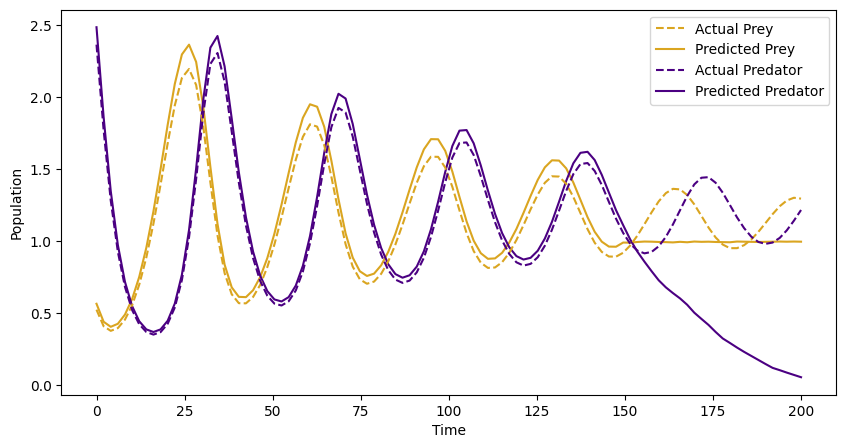

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(full_times, actual_prey, label="Actual Prey", linestyle="--", zorder=100, color="goldenrod")
ax.plot(full_times, pred_prey, label="Predicted Prey", color="goldenrod")
ax.plot(full_times, actual_predator, label="Actual Predator", linestyle="--", zorder=100, color="indigo")
ax.plot(full_times, pred_predator, label="Predicted Predator", color="indigo")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.legend()
plt.show()

In [63]:
print("MEAN PREY SQUARED ERROR:", mean_squared_error(pred_prey, actual_prey))
print("MEAN PREY ABSOLUTE ERROR:", mean_absolute_error(pred_prey, actual_prey))
print("R2 PREY SCORE:", r2_score(pred_prey, actual_prey))
print("MEAN PREDATOR SQUARED ERROR:", mean_squared_error(pred_predator, actual_predator))
print("MEAN PREDATOR ABSOLUTE ERROR:", mean_absolute_error(pred_predator, actual_predator))
print("R2 PREDATOR SCORE:", r2_score(pred_predator, actual_predator))

MEAN PREY SQUARED ERROR: 0.017707150195790465
MEAN PREY ABSOLUTE ERROR: 0.10791000176429748
R2 PREY SCORE: 0.8961812474290289
MEAN PREDATOR SQUARED ERROR: 0.16180548168589684
MEAN PREDATOR ABSOLUTE ERROR: 0.22234000344514848
R2 PREDATOR SCORE: 0.5163889778006054


In [76]:
prey_mse_list = []
prey_mae_list = []
prey_r2_list = []
predator_mse_list = []
predator_mae_list = []
predator_r2_list = []

for i in tqdm.tqdm(range(1000), desc="calculating", unit="it"):

    tokenized_data, preprocessed_data, combined_data, times = process_data(system_id=i, points=75, alpha=40, decimals=3)
    max_new_tokens = max_token_length - tokenized_data["input_ids"].shape[1]
    max_new_tokens = max(1, max_new_tokens)
    
    with torch.no_grad():
        output = model.generate(tokenized_data["input_ids"], attention_mask=tokenized_data["attention_mask"], max_new_tokens=max_new_tokens)
    
    prediction = tokenizer.decode(output[0])

    pred_prey, pred_predator = decoding(prediction)
    actual_prey, actual_predator = full_combined_data[:, 2], full_combined_data[:, 3]

    prey_mse = mean_squared_error(pred_prey, actual_prey)
    prey_mae = mean_absolute_error(pred_prey, actual_prey)
    prey_r2 = r2_score(pred_prey, actual_prey)
    predator_mse = mean_squared_error(pred_predator, actual_predator)
    predator_mae = mean_absolute_error(pred_predator, actual_predator)
    predator_r2 = r2_score(pred_predator, actual_predator)
    
    prey_mse_list.append(prey_mse)
    prey_mae_list.append(prey_mae)
    prey_r2_list.append(prey_r2)
    predator_mse_list.append(predator_mse)
    predator_mae_list.append(predator_mae)
    predator_r2_list.append(predator_r2)

metrics_df = pd.DataFrame({
    'prey_mse': prey_mse_list,
    'prey_mae': prey_mae_list,
    'prey_r2': prey_r2_list,
    'predator_mse': predator_mse_list,
    'predator_mae': predator_mae_list,
    'predator_r2': predator_r2_list
})

metrics_df.to_csv("metrics_results.csv", index=False)

calculating:   0%|          | 0/1000 [00:00<?, ?it/s]

calculating:   0%|          | 2/1000 [02:14<18:34:28, 67.00s/it]


ValueError: could not convert string to float: ''

In [ ]:
# def calculate_flops(batch_size, sequence_length, embedding_dim, num_heads, num_layers):
#     token_embedding = batch_size * sequence_length * (embedding_dim * 2 - 1)
    
#     attention = (batch_size * sequence_length * (embedding_dim * 2 - 1)*3 + 
#                  batch_size * num_heads * sequence_length**2 * 2 )